In [7]:
from sklearn.metrics import accuracy_score, r2_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# XGBoost

In [8]:
train_dataset = pd.read_csv("train.csv").convert_dtypes()
test_dataset =pd.read_csv("test.csv").convert_dtypes()

In [9]:
categorical_columns = ['promotion', 'brand', 'manufacturer', 'category1', 'category2', 'category3']

# Option 1: Convert in the original datasets
train_dataset[categorical_columns] = train_dataset[categorical_columns].astype('category')
test_dataset[categorical_columns] = test_dataset[categorical_columns].astype('category')

In [10]:
features = ['itemID', 'qty_sold_lag1', 'qty_sold_lag2',
       'qty_sold_lag3', 'qty_sold_lag7', 'promotion', 'maxItemPrice',
       'minItemPrice', 'Price', 'PriceToday', 'medianDiscPerc', 'brand',
       'manufacturer', 'customerRating', 'category1', 'category2', 'category3',
       'recommendedRetailPrice', 'weekDay', 'day', 'weekOfMonth', 'harmonic_0',
       'harmonic_1', 'harmonic_2', 'harmonic_3', 'harmonic_4', 'cum_sum_order',
       'rolling_qty_sold_mean', 'rolling_qty_sold_std',
       'rolling_qty_sold_median', 'PricePerEach_lag1', 'PricePerEach_lag2',
       'PricePerEach_lag3', 'PricePerEach_lag7', 'sales_value_lag1',
       'sales_value_lag2', 'sales_value_lag3', 'sales_value_lag7',
       'random_noise1', 'random_noise2']
X_train = train_dataset[features]
X_test = test_dataset[features]
y_train = train_dataset["qty_sold"]
y_test = test_dataset["qty_sold"]

In [11]:
xgb_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [12]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'random_state': 42
}
n=50
model = xgb.train(params=params,dtrain=xgb_train,num_boost_round=n)

c:\Users\kriss\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:00:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:
preds = model.predict(xgb_test)
preds = np.round(preds)
accuracy = accuracy_score(y_test, preds)
xgb_r2_score = r2_score(y_test, preds)
print('Accuracy of the model is:', accuracy*100)
print("R2 score of the model is:", xgb_r2_score)

Accuracy of the model is: 70.10014674458719
R2 score of the model is: 0.6660888195037842


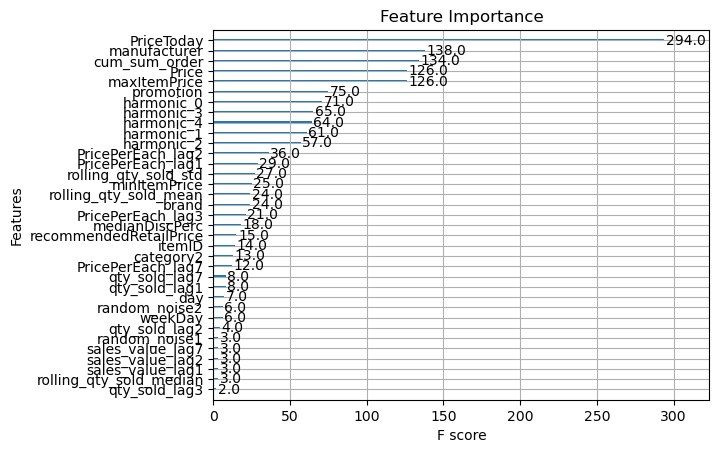

In [14]:
# Feature importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

# Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor(max_depth=5, random_state=42)
regr.fit(X_train, y_train)
regr_r2_score = regr.score(X_test, y_test)
print("R2 score of the model is:", regr_r2_score)

KeyboardInterrupt: 